In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go 
#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score,roc_curve
from sklearn.cluster import KMeans
import time
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [5]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [6]:
df['Cabin'] = df['Cabin'].fillna('Other')

In [7]:
df['Embarked'] = df['Embarked'].fillna('S')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
#Identify the features' characteristcs.
unique_counts = df.nunique()
print(unique_counts)

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             89
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          148
Embarked         3
dtype: int64


In [10]:
##Feature Engineering// Dummies
Embarked_mapping = {'S':1, 'Q':2,'C':3}
df['Embarked'] = df['Embarked'].map(Embarked_mapping)

In [11]:
##Feature Engineering// Dummies
gender_mapping = {'male':1, 'female':2}
df['Sex'] = df['Sex'].map(gender_mapping)

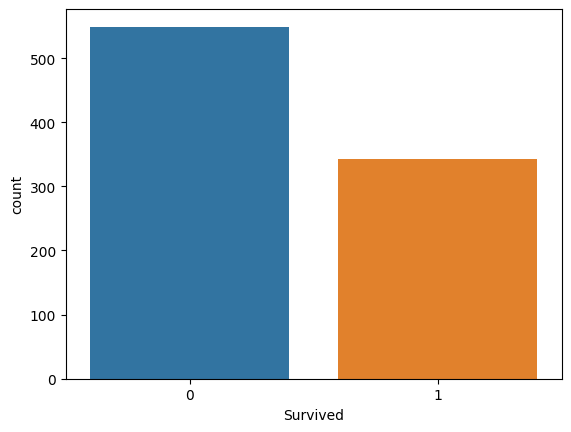

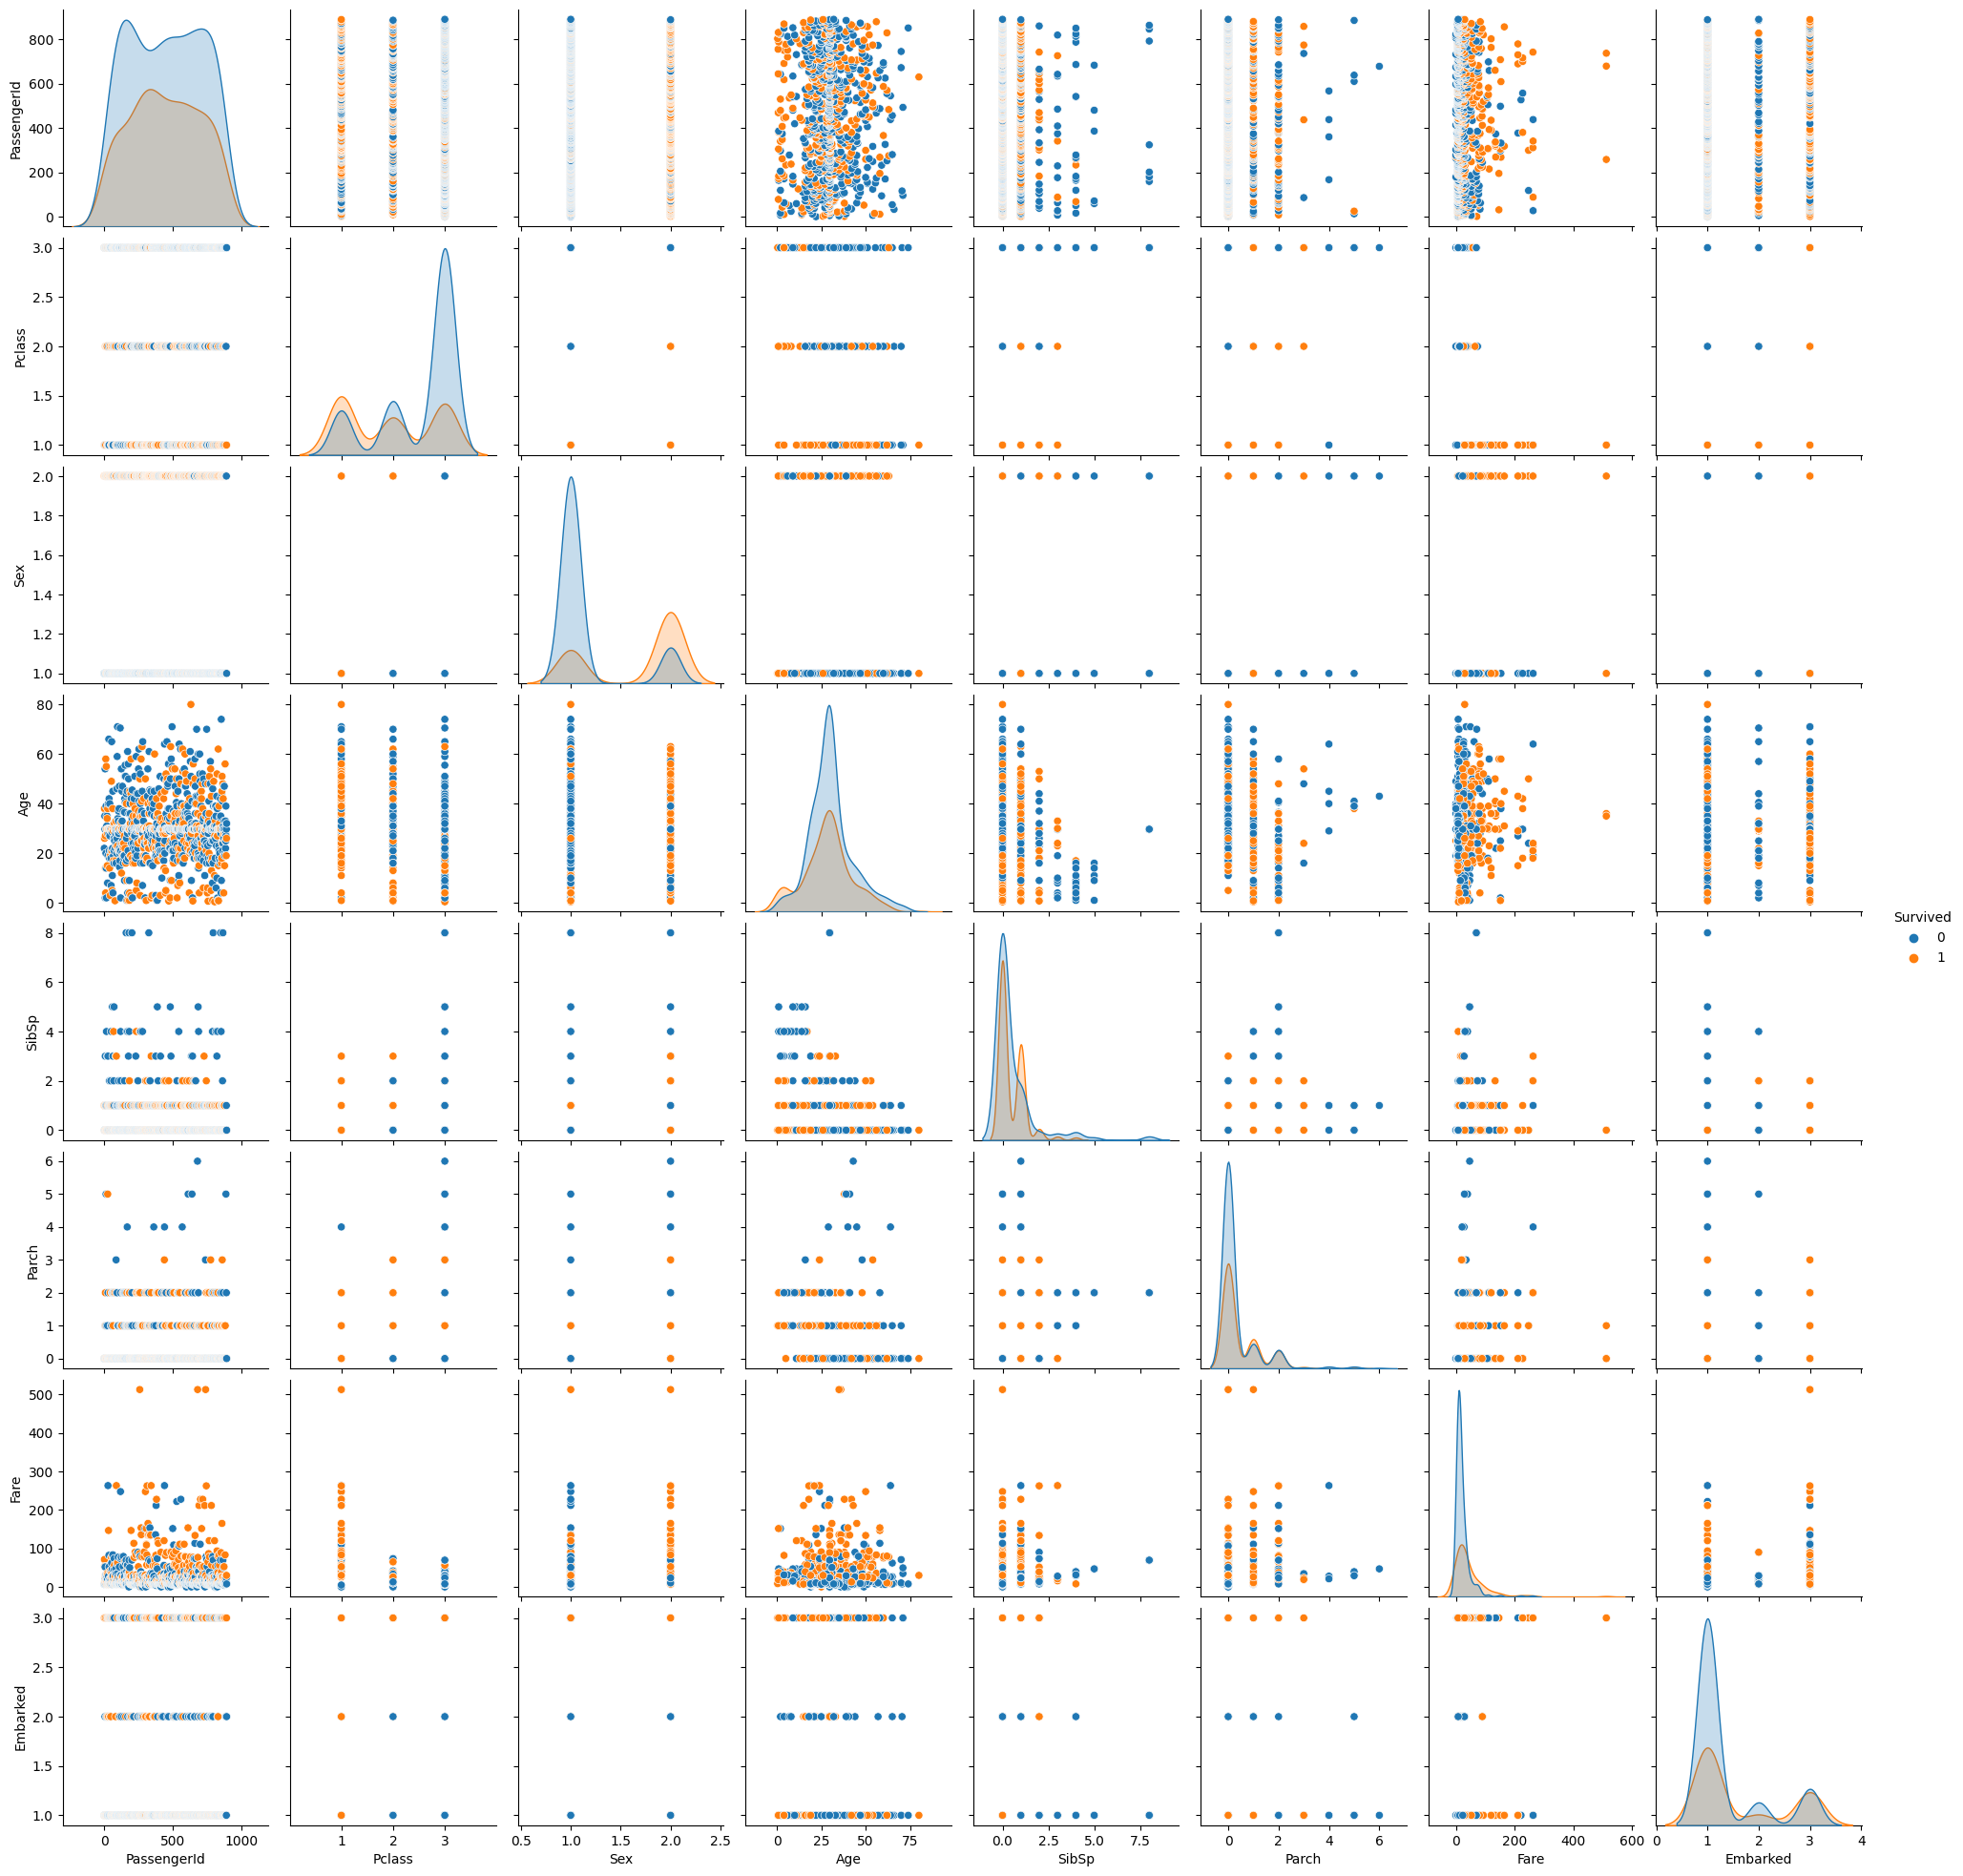

In [12]:
# Display the distribution of 'Survived'
sns.countplot(x='Survived', data=df)
plt.show()

# More detailed exploration
sns.pairplot(df, hue='Survived')
plt.show()


<Axes: xlabel='Survived', ylabel='Fare'>

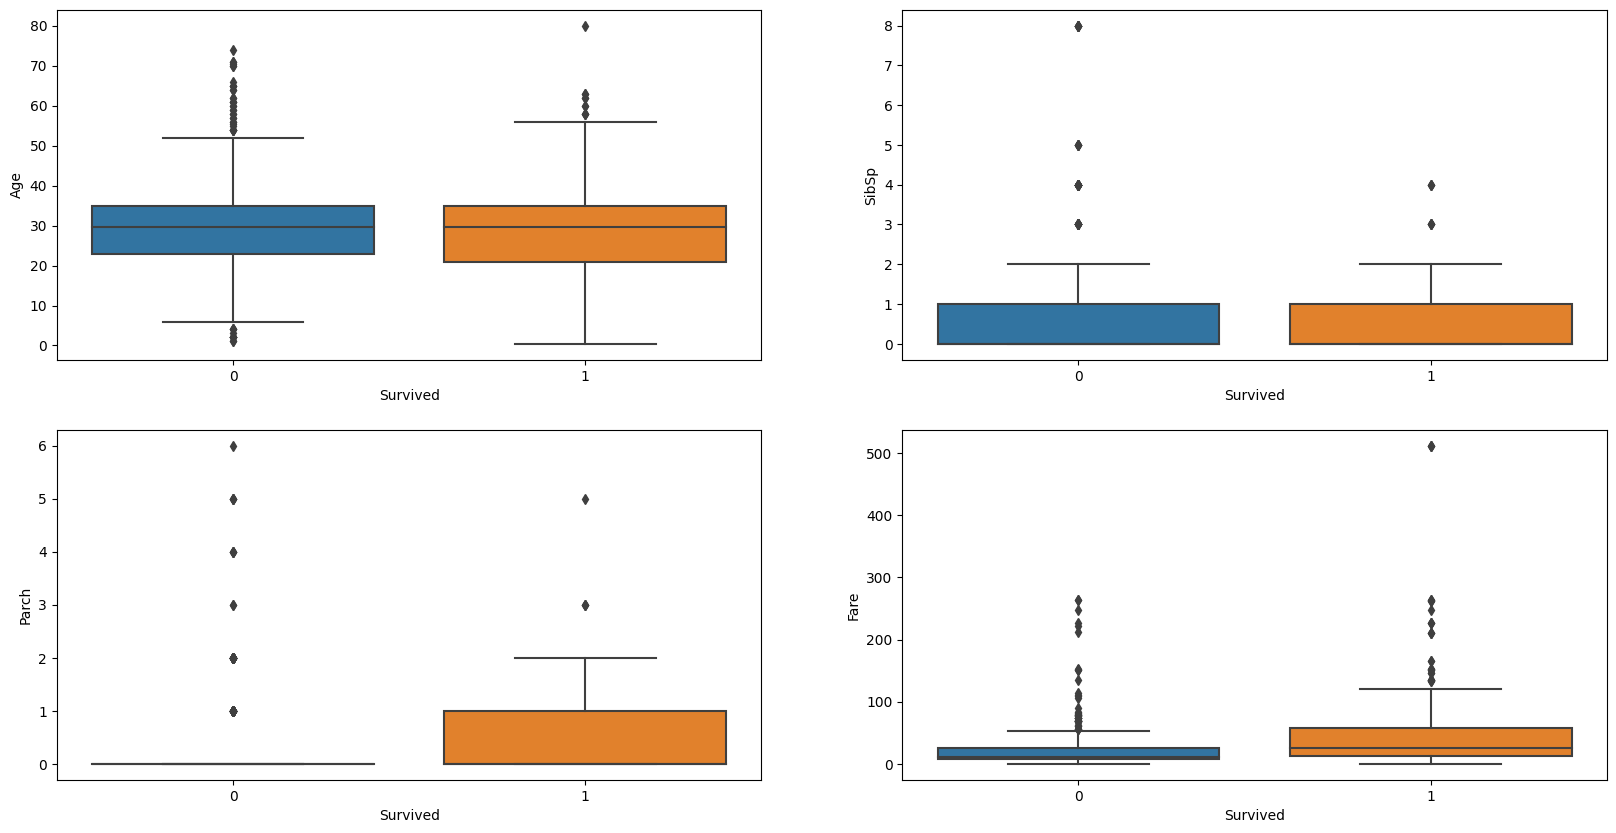

In [13]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(20,10))
sns.boxplot(x='Survived', y='Age', ax=ax1, data=df)
sns.boxplot(x='Survived', y='SibSp', ax=ax2, data=df)
sns.boxplot(x='Survived', y='Parch', ax=ax3, data=df)
sns.boxplot(x='Survived', y='Fare', ax=ax4, data=df)

<Axes: xlabel='Survived', ylabel='Embarked'>

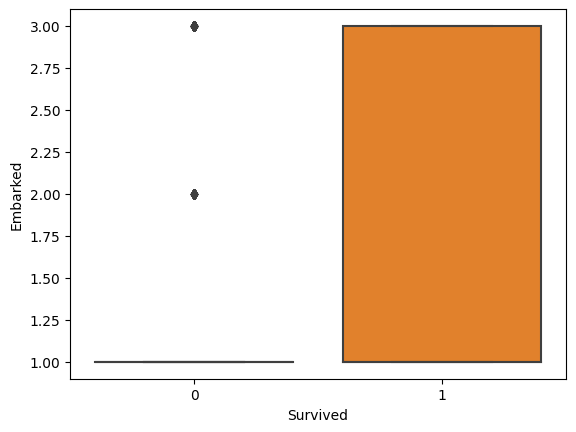

In [14]:
sns.boxplot(x='Survived', y='Embarked', data=df)

In [15]:
categorized_feature = ['Pclass']
numerical_feature = ['Fare','SibSp','Parch']

target = ['Survived']

In [16]:
X = df[categorized_feature + numerical_feature]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
##Looking for which prediction model is the best
knn = KNeighborsClassifier()
nb = GaussianNB()
svc = SVC(kernel='linear')

In [18]:
knn.fit(X_train, y_train)
nb.fit(X_train, y_train)
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [19]:
# KNN pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', knn)
])

# Naive Bayes pipeline
nb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', nb)
])

# SVC pipeline
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', svc)])

# Integrate Pipelines
pipelines = [knn_pipeline, nb_pipeline, svc_pipeline]

# Number of bootstrap samples and trees in the ensemble
n_samples = len(X_train)
n_trees = 50

# Sampling function
def bootstrap_sample(X, y):
    indices = np.random.choice(len(X), size=len(X), replace=True)
    return X.iloc[indices].reset_index(drop=True), y.iloc[indices].reset_index(drop=True)


In [20]:
from sklearn.base import clone

trees = []

for _ in range(n_trees):
    X_sample, y_sample = bootstrap_sample(X_train, y_train)
    
    for pipeline in pipelines:
        cloned_pipeline = clone(pipeline)
        cloned_pipeline.fit(X_sample, y_sample)
        trees.append(cloned_pipeline)


In [21]:
# Aggregate predictions
predictions = np.zeros((len(X_test), len(trees)))
for tree_index, tree in enumerate(trees):
    predictions[:, tree_index] = tree.predict(X_test)

In [22]:
predictions

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]])